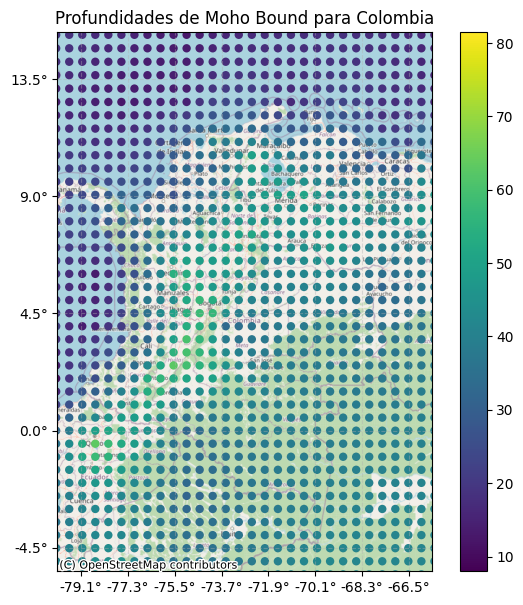

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.ticker import FuncFormatter
# Ruta al archivo shapefile (.shp)
ruta = r"C:\Git_SCA\AGE\Corteza"  # Usa r"" para evitar problemas con backslashes
# Cargar el shapefile
gdf = gpd.read_file(ruta)
# Reproyectar al sistema de Web Mercator (requerido por contextily)
gdf = gdf.to_crs(epsg=3857)
# Función para convertir de Web Mercator a grados decimales (aproximado)
def mercator_to_lon(x, _):
    return f"{x * 180 / 20037508.34:.1f}°"
def mercator_to_lat(y, _):
    return f"{y * 180 / 20037508.34:.1f}°"
# Crear el gráfico
fig, ax = plt.subplots(figsize=(7, 7))
# Graficar el shapefile con color según 'Z'
gdf.plot(
    column='Z',
    cmap='viridis',
    legend=True,
    ax=ax,
    linewidth=0.01,
    edgecolor='black'
)
# Centrar el mapa en Colombia (coordenadas en Web Mercator)
ax.set_xlim([-8900000, -7300000])
ax.set_ylim([-600000, 1700000])
# Formatear los ejes con coordenadas bonitas
ax.xaxis.set_major_formatter(FuncFormatter(mercator_to_lon))
ax.yaxis.set_major_formatter(FuncFormatter(mercator_to_lat))
# Añadir líneas de grilla suaves
ax.grid(True, which='major', linestyle='--', alpha=0.4)
# Añadir el mapa base
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
# Título y visualización
plt.title("Profundidades de Moho Bound para Colombia")
#ax.set_axis_off()  # Si prefieres mostrar solo el mapa sin ejes, descomenta esta línea
plt.show()

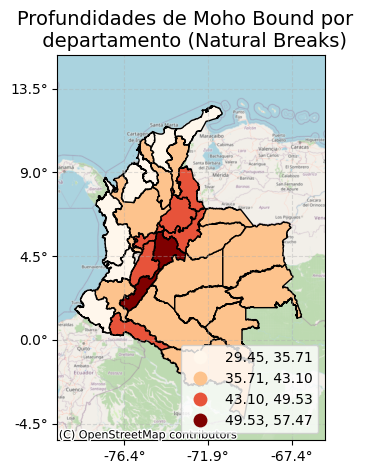

In [1]:

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.ticker import FuncFormatter

# Ruta al shapefile con columna 'Z'
ruta_z = r"C:/Git_SCA\AGE/Corteza"
gdf = gpd.read_file(ruta_z)

# Ruta al shapefile de departamentos (polígonos)
ruta_dpto = r"C:/Git_SCA/AGE/departamentos"
departamentos = gpd.read_file(ruta_dpto)

# Asegurar mismo CRS
if gdf.crs is None:
    gdf.set_crs(epsg=4326, inplace=True)
if departamentos.crs != gdf.crs:
    departamentos = departamentos.to_crs(gdf.crs)

# Spatial join: asociar puntos/zonas con 'Z' a departamentos
joined = gpd.sjoin(gdf, departamentos, predicate='within')

# Calcular promedio de Z por departamento (ajusta el nombre si no es 'NOMBRE_DPT')
promedios = joined.groupby('DeNombre')['Z'].mean().reset_index()
promedios.rename(columns={'Z': 'Z_promedio'}, inplace=True)

# Unir promedios al GeoDataFrame de departamentos
departamentos = departamentos.merge(promedios, on='DeNombre', how='left')

# Reproyectar para contexto de mapa base
departamentos = departamentos.to_crs(epsg=3857)

# Funciones para mostrar ejes en grados
def mercator_to_lon(x, _): return f"{x * 180 / 20037508.34:.1f}°"
def mercator_to_lat(y, _): return f"{y * 180 / 20037508.34:.1f}°"

# Crear figura y eje
fig, ax = plt.subplots(1, figsize=(5, 5))

# Mapa tipo choropleth
departamentos.plot(
    column='Z_promedio',
    cmap='OrRd',
    scheme='natural_breaks',
    k=4,
    legend=True,
    edgecolor='black',
    legend_kwds={'loc': 'lower right'},
    ax=ax
)

# Limitar a Colombia (EPSG:3857)
ax.set_xlim([-8900000, -7300000])
ax.set_ylim([-600000, 1700000])

# Ejes bonitos en grados
ax.xaxis.set_major_formatter(FuncFormatter(mercator_to_lon))
ax.yaxis.set_major_formatter(FuncFormatter(mercator_to_lat))
ax.grid(True, linestyle="--", alpha=0.4)

# Mapa base estándar de OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:3857')

# Título del mapa
ax.set_title("Profundidades de Moho Bound por  \n departamento (Natural Breaks)", fontsize=14)
plt.show()


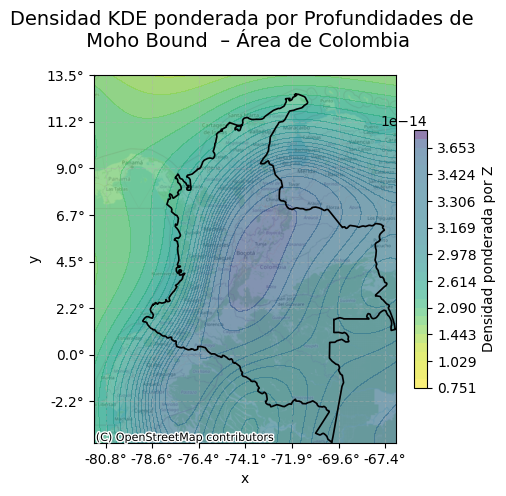

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import FuncFormatter
import numpy as np

# === 1. Cargar puntos con Z ===
gdf = gpd.read_file("C:/Git_SCA/AGE/Corteza").to_crs(epsg=3857)

# === 2. Cargar shapefile único de Colombia ===
colombia = gpd.read_file("C:/Git_SCA/AGE/Area_Col").to_crs(epsg=3857)
colombia = colombia[~colombia.geometry.is_empty & colombia.geometry.is_valid]

# === 3. Filtrar puntos dentro de Colombia ===
#gdf = gdf[gdf.geometry.within(colombia.unary_union)]

# === 4. Convertir a DataFrame plano para Seaborn ===
df = pd.DataFrame({
    'x': gdf.geometry.x,
    'y': gdf.geometry.y,
    'z': gdf['Z']
})

# === 5. Crear figura ===
fig, ax = plt.subplots(figsize=(5, 5))

# KDE ponderada por Z
kde = sns.kdeplot(
    data=df,
    x='x', y='y',
    weights='z',
    fill=True,
    cmap='viridis_r',
    alpha=0.6,
    bw_adjust=0.6,
    levels=30,
    ax=ax
)

# Añadir contorno de Colombia
colombia.boundary.plot(ax=ax, edgecolor='black', linewidth=1.2)

# === 6. Coordenadas en grados ===
def mercator_to_lon(x, _): return f"{x * 180 / 20037508.34:.1f}°"
def mercator_to_lat(y, _): return f"{y * 180 / 20037508.34:.1f}°"
ax.xaxis.set_major_formatter(FuncFormatter(mercator_to_lon))
ax.yaxis.set_major_formatter(FuncFormatter(mercator_to_lat))
ax.grid(True, linestyle="--", alpha=0.4)

# === 7. Centrar el mapa en Colombia ===
bounds = colombia.total_bounds
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

# === 8. Añadir barra de color ===
# Seaborn no expone el mapeo de color directamente, por eso usamos la imagen como workaround
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:3857')
mappable = ax.collections[0]
cbar = plt.colorbar(mappable, ax=ax, shrink=0.7, label="Densidad ponderada por Z")

# === 9. Estética final ===
plt.title("Densidad KDE ponderada por Profundidades de \n Moho Bound  – Área de Colombia", fontsize=14, pad=20)
plt.tight_layout()
plt.show()
